In [124]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

BP_PRIMARY = "#0c7eab"
BP_SECONDARY = "#219955"
BP_ACCENT = '#d4a017'
BP_LIGHT = "#6a93c1"

REQ_PRIMARY = '#c0392b'
REQ_SECONDARY = '#e74c3c'
REQ_LIGHT = '#f1948a'

MDS_PRIMARY = '#6c3483'
MDS_SECONDARY = '#8e44ad'
MDS_LIGHT = '#bb8fce'

# Referências
REF_LIMIT = '#7f8c8d'

INPUT_FILE = 'prs.csv'

df_raw = pd.read_csv(INPUT_FILE)
df = df_raw[(df_raw['org'] == 'lappis-unb') & (df_raw['repo'] == 'brasilparticipativo')].copy()
org_title = "Brasil Participativo"

df_mds = df_raw[df_raw['org'] == 'unb-mds'].copy()
df_req = df_raw[df_raw['org'] == 'mdsreq-fga-unb'].copy()
mds_title = "MDS (unb-mds)"
req_title = "REQ (mdsreq-fga-unb)"

print(f"Brasil Participativo: {len(df)} registros")
print(f"MDS: {len(df_mds)} registros")
print(f"REQ: {len(df_req)} registros")

Brasil Participativo: 510 registros
MDS: 975 registros
REQ: 452 registros


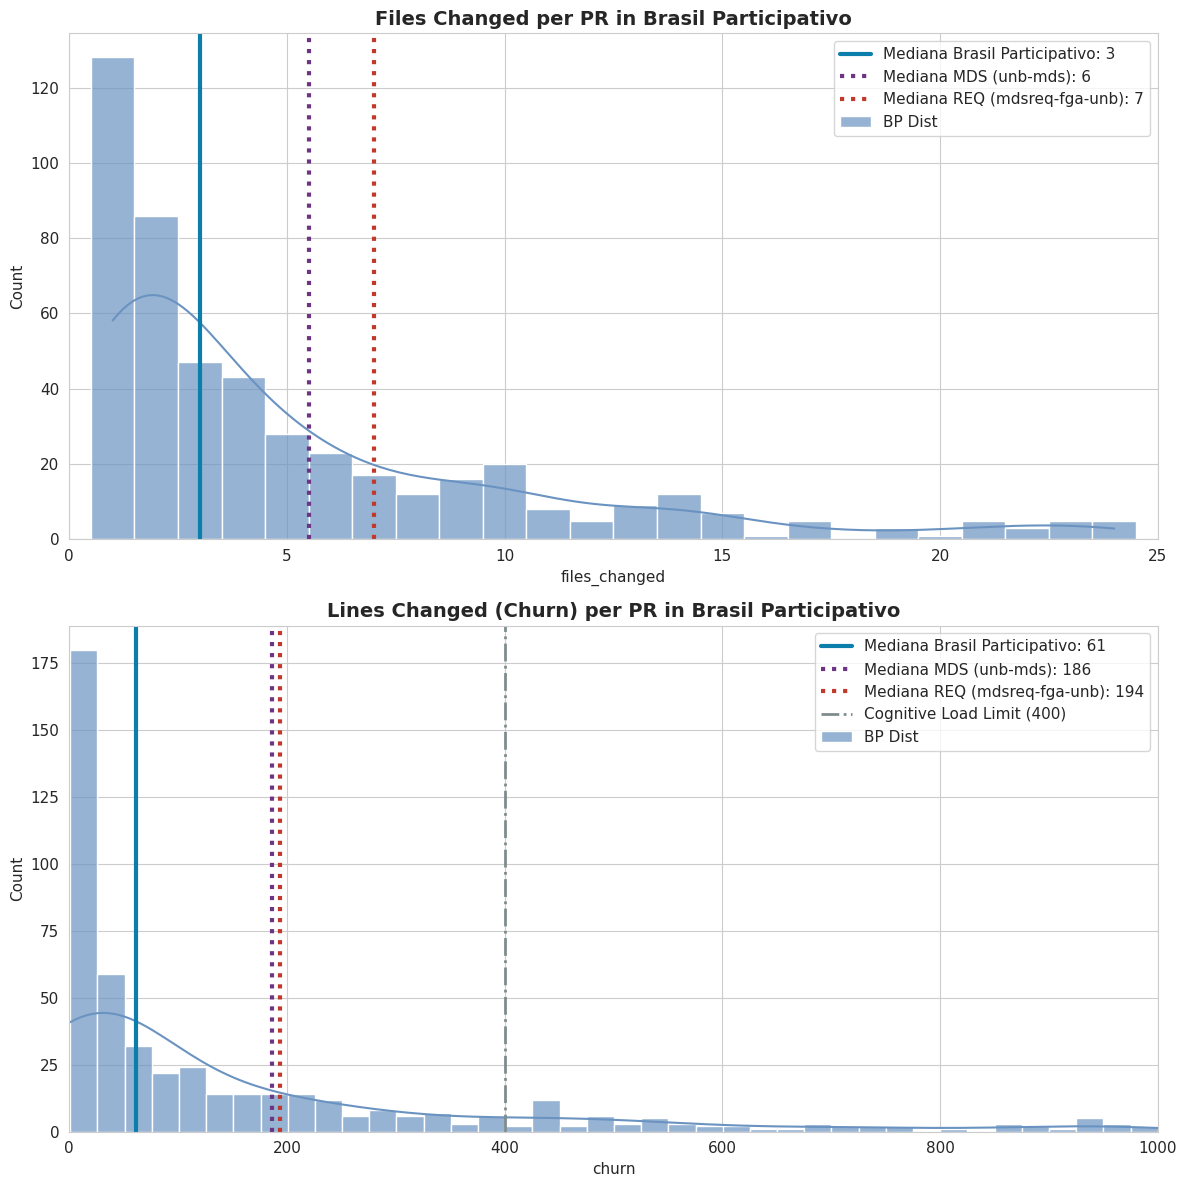

In [125]:
def plot_size_complexity_multi_bench(df_lab, df_mds, df_req, lab_label="BP", mds_label="MDS", req_label="Req"):
    clean_lab = df_lab[(df_lab['files_changed'] > 0) & (df_lab['churn'] > 0)].copy()
    clean_mds = df_mds[(df_mds['files_changed'] > 0) & (df_mds['churn'] > 0)].copy()
    clean_req = df_req[(df_req['files_changed'] > 0) & (df_req['churn'] > 0)].copy()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    p50_files_lab = clean_lab['files_changed'].median()
    p50_files_mds = clean_mds['files_changed'].median()
    p50_files_req = clean_req['files_changed'].median()
    p50_churn_lab = clean_lab['churn'].median()
    p50_churn_mds = clean_mds['churn'].median()
    p50_churn_req = clean_req['churn'].median()

    subset_files = clean_lab[clean_lab['files_changed'] <= 25]['files_changed']
    sns.histplot(subset_files, discrete=True, color=BP_LIGHT, edgecolor='white', alpha=0.7, ax=ax1, label='BP Dist', kde=True)
    
    ax1.axvline(p50_files_lab, color=BP_PRIMARY, linewidth=3, label=f'Mediana {lab_label}: {p50_files_lab:.0f}')
    ax1.axvline(p50_files_mds, color=MDS_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {mds_label}: {p50_files_mds:.0f}')
    ax1.axvline(p50_files_req, color=REQ_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {req_label}: {p50_files_req:.0f}')
    ax1.set_title('Files Changed per PR in Brasil Participativo', fontsize=14, fontweight='bold')
    ax1.set_xlim(0, 25)
    ax1.legend()

    subset_churn = clean_lab[clean_lab['churn'] <= 1000]['churn']
    sns.histplot(subset_churn, binwidth=25, kde=True, color=BP_LIGHT, edgecolor='white', alpha=0.7, ax=ax2, label='BP Dist')
    
    ax2.axvline(p50_churn_lab, color=BP_PRIMARY, linewidth=3, label=f'Mediana {lab_label}: {p50_churn_lab:.0f}')
    ax2.axvline(p50_churn_mds, color=MDS_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {mds_label}: {p50_churn_mds:.0f}')
    ax2.axvline(p50_churn_req, color=REQ_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {req_label}: {p50_churn_req:.0f}')
    ax2.axvline(400, color=REF_LIMIT, linewidth=2, linestyle='-.', label='Cognitive Load Limit (400)')
    ax2.set_title('Lines Changed (Churn) per PR in Brasil Participativo', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 1000)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_size_complexity_multi_bench(df, df_mds, df_req, lab_label=org_title, mds_label=mds_title, req_label=req_title)

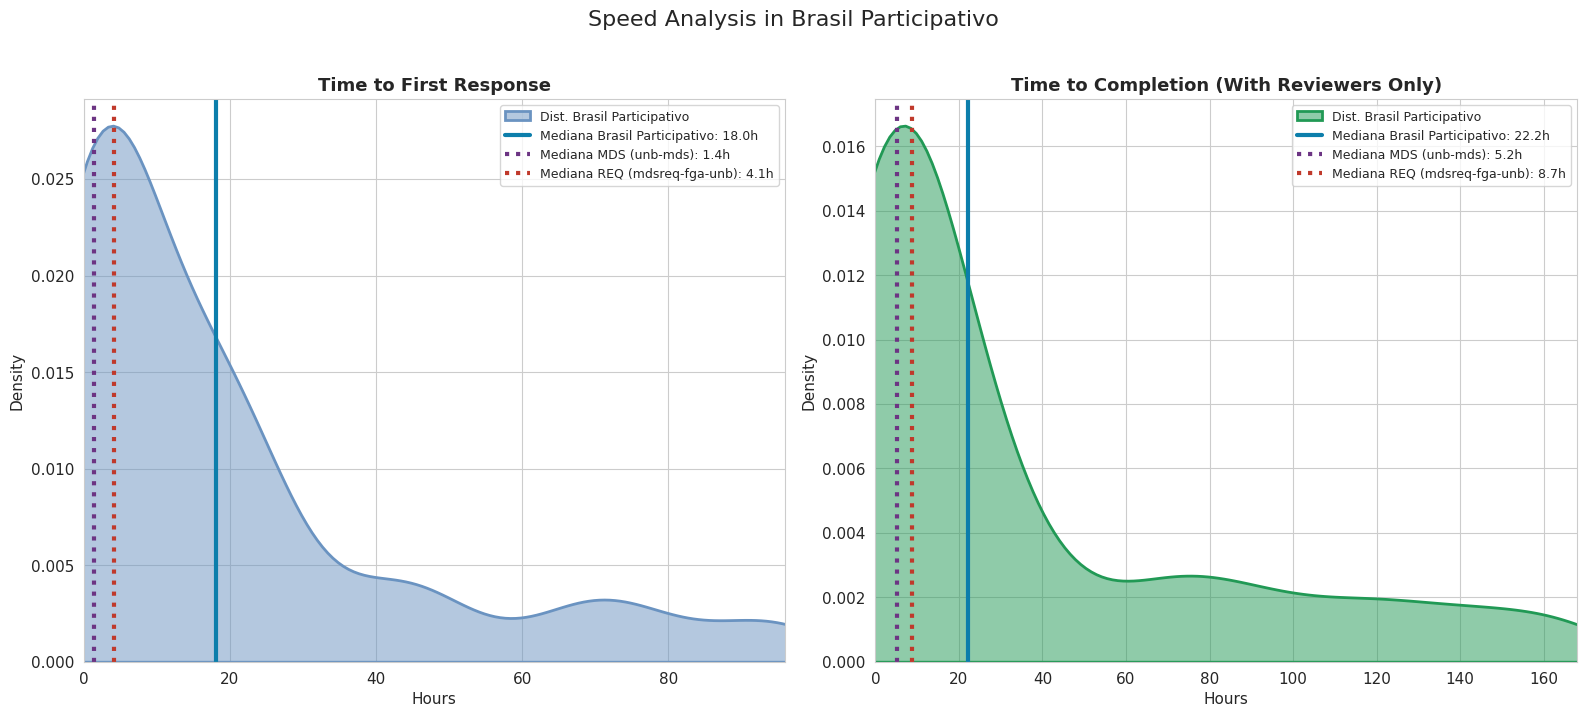

In [126]:
def plot_review_speed_rigby_final(df_lab, df_mds, df_req, lab_label="BP", mds_label="MDS", req_label="Req"):
    df_lab_rev = df_lab[df_lab['reviewers'].notna() & (df_lab['reviewers'] != "")].copy()
    df_mds_rev = df_mds[df_mds['reviewers'].notna() & (df_mds['reviewers'] != "")].copy()
    df_req_rev = df_req[df_req['reviewers'].notna() & (df_req['reviewers'] != "")].copy()

    clean_resp_lab = df_lab_rev[df_lab_rev['time_to_first_review_hours'] > 0.01]['time_to_first_review_hours']
    clean_comp_lab = df_lab_rev[df_lab_rev['lead_time_hours'] > 0.01]['lead_time_hours']
    clean_resp_mds = df_mds_rev[df_mds_rev['time_to_first_review_hours'] > 0.01]['time_to_first_review_hours']
    clean_comp_mds = df_mds_rev[df_mds_rev['lead_time_hours'] > 0.01]['lead_time_hours']
    clean_resp_req = df_req_rev[df_req_rev['time_to_first_review_hours'] > 0.01]['time_to_first_review_hours']
    clean_comp_req = df_req_rev[df_req_rev['lead_time_hours'] > 0.01]['lead_time_hours']
    
    viz_resp_lab = clean_resp_lab[clean_resp_lab <= 96]
    viz_comp_lab = clean_comp_lab[clean_comp_lab <= 168]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    sns.kdeplot(viz_resp_lab, fill=True, color=BP_LIGHT, alpha=0.5, linewidth=2, ax=ax1, label=f'Dist. {lab_label}')
    
    med_resp_lab = clean_resp_lab.median()
    med_resp_mds = clean_resp_mds.median()
    med_resp_req = clean_resp_req.median()
    
    ax1.axvline(med_resp_lab, color=BP_PRIMARY, linewidth=3, label=f'Mediana {lab_label}: {med_resp_lab:.1f}h')
    ax1.axvline(med_resp_mds, color=MDS_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {mds_label}: {med_resp_mds:.1f}h')
    ax1.axvline(med_resp_req, color=REQ_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {req_label}: {med_resp_req:.1f}h')
    ax1.set_title('Time to First Response', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Hours')
    ax1.set_xlim(0, 96)
    ax1.legend(fontsize=9)

    sns.kdeplot(viz_comp_lab, fill=True, color=BP_SECONDARY, alpha=0.5, linewidth=2, ax=ax2, label=f'Dist. {lab_label}')
    
    med_comp_lab = clean_comp_lab.median()
    med_comp_mds = clean_comp_mds.median()
    med_comp_req = clean_comp_req.median()
    
    ax2.axvline(med_comp_lab, color=BP_PRIMARY, linewidth=3, label=f'Mediana {lab_label}: {med_comp_lab:.1f}h')
    ax2.axvline(med_comp_mds, color=MDS_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {mds_label}: {med_comp_mds:.1f}h')
    ax2.axvline(med_comp_req, color=REQ_PRIMARY, linewidth=3, linestyle=':', label=f'Mediana {req_label}: {med_comp_req:.1f}h')
    ax2.set_title('Time to Completion (With Reviewers Only)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Hours')
    ax2.set_xlim(0, 168)
    ax2.legend(fontsize=9)
    
    plt.suptitle(f"Speed Analysis in {lab_label}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_review_speed_rigby_final(df, df_mds, df_req, lab_label=org_title, mds_label=mds_title, req_label=req_title)

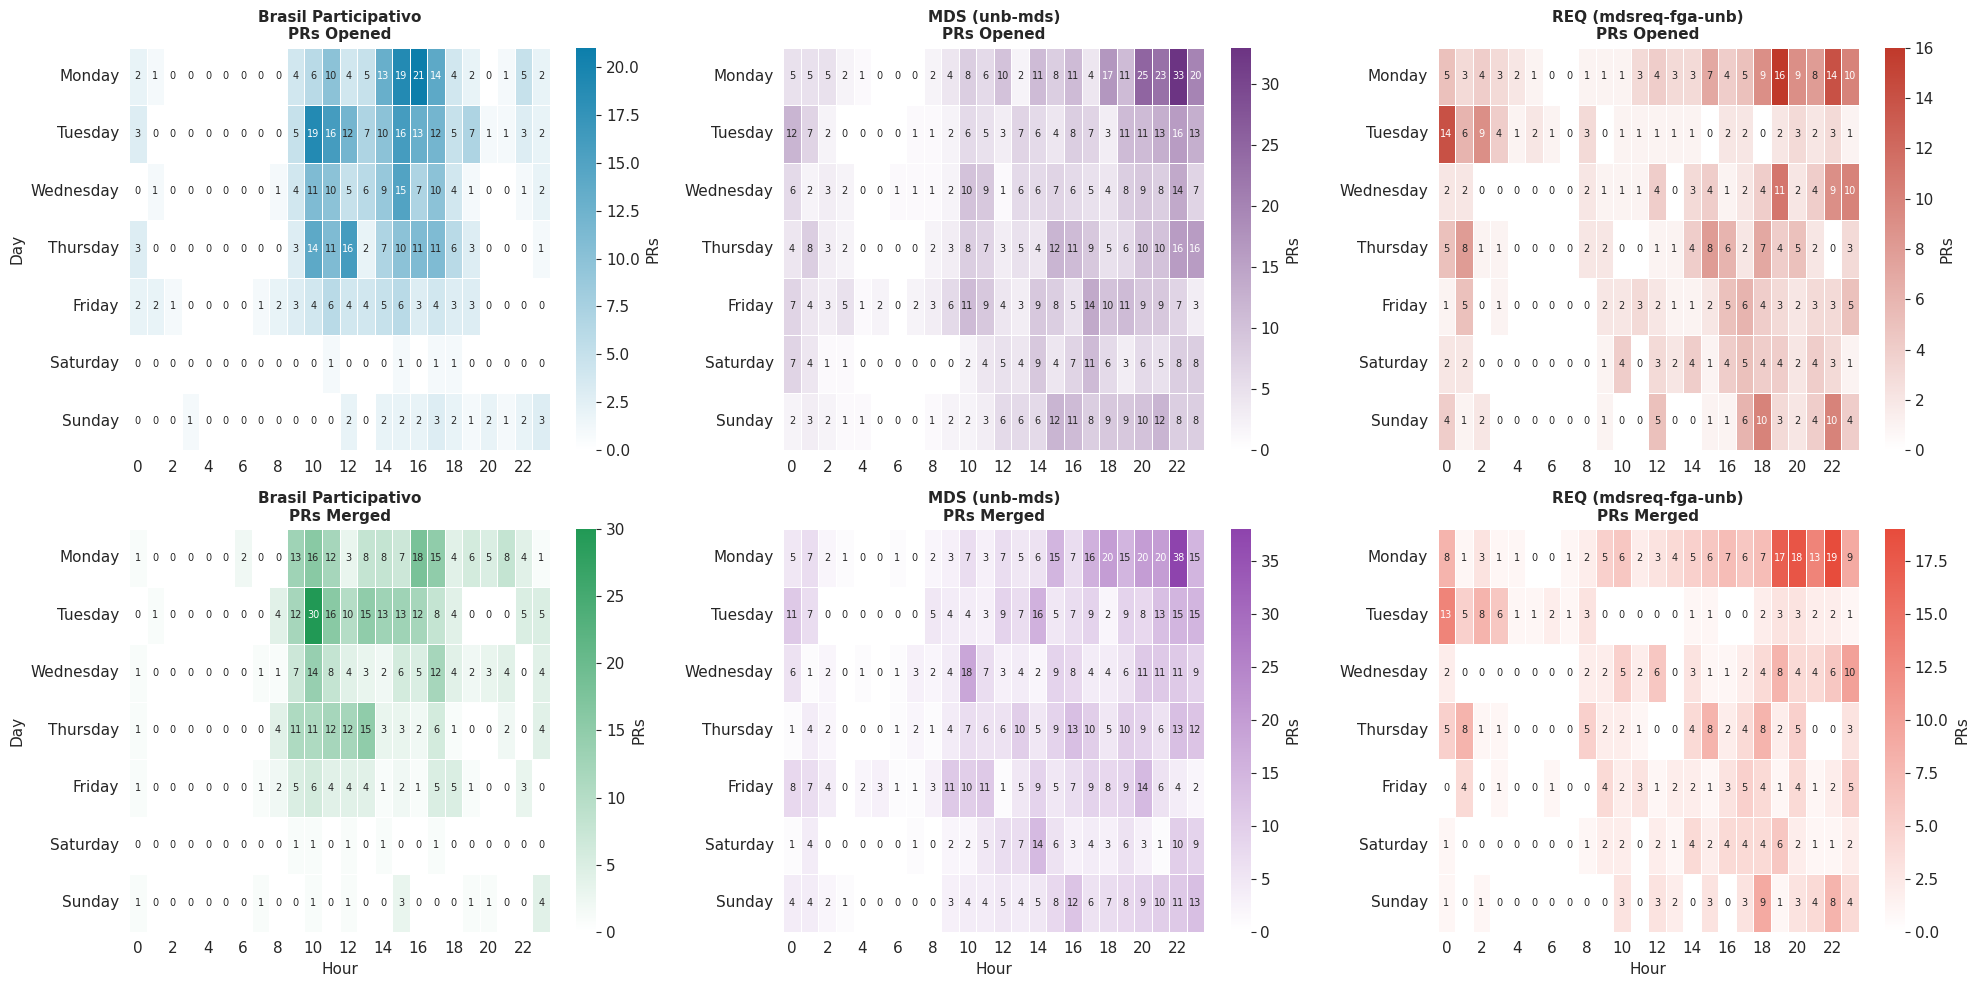

In [127]:
from matplotlib.colors import LinearSegmentedColormap

def plot_activity_heatmaps_comparison(df_bp, df_mds, df_req):
    def prepare_data(data):
        data = data.copy()
        data['created_at'] = pd.to_datetime(data['created_at'], utc=True)
        data['merged_at'] = pd.to_datetime(data['merged_at'], utc=True)
        try:
            data['created_at_br'] = data['created_at'].dt.tz_convert('America/Sao_Paulo')
            data['merged_at_br'] = data['merged_at'].dt.tz_convert('America/Sao_Paulo')
        except:
            data['created_at_br'] = data['created_at']
            data['merged_at_br'] = data['merged_at']
        return data

    def get_heatmap_data(data, column):
        temp = data[['id', column]].dropna().copy()
        temp['day_name'] = temp[column].dt.day_name()
        temp['hour'] = temp[column].dt.hour
        pivot = temp.groupby(['day_name', 'hour']).size().unstack(fill_value=0)
        days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        pivot = pivot.reindex(days_order).fillna(0).astype(int)
        for h in range(24):
            if h not in pivot.columns:
                pivot[h] = 0
        return pivot[sorted(pivot.columns)]

    # Criação dos Colormaps baseados nas suas variáveis
    cmap_bp_open = LinearSegmentedColormap.from_list("bp_open", ["#ffffff", BP_PRIMARY])
    cmap_bp_merge = LinearSegmentedColormap.from_list("bp_merge", ["#ffffff", BP_SECONDARY])
    
    cmap_req_open = LinearSegmentedColormap.from_list("req_open", ["#ffffff", REQ_PRIMARY])
    cmap_req_merge = LinearSegmentedColormap.from_list("req_merge", ["#ffffff", REQ_SECONDARY])
    
    cmap_mds_open = LinearSegmentedColormap.from_list("mds_open", ["#ffffff", MDS_PRIMARY])
    cmap_mds_merge = LinearSegmentedColormap.from_list("mds_merge", ["#ffffff", MDS_SECONDARY])

    df_bp = prepare_data(df_bp)
    df_mds = prepare_data(df_mds)
    df_req = prepare_data(df_req)

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    
    # Essa parte é para utilizar a paleta de cores definida para Brasil Participativo, MDS e Requisitos

    sns.heatmap(get_heatmap_data(df_bp, 'created_at_br'), cmap=cmap_bp_open, annot=True, fmt='d', linewidths=.5, ax=axes[0,0], cbar_kws={'label': 'PRs'}, annot_kws={'size': 7})
    axes[0,0].set_title(f'{org_title}\nPRs Opened', fontsize=11, fontweight='bold')
    
    sns.heatmap(get_heatmap_data(df_bp, 'merged_at_br'), cmap=cmap_bp_merge, annot=True, fmt='d', linewidths=.5, ax=axes[1,0], cbar_kws={'label': 'PRs'}, annot_kws={'size': 7})
    axes[1,0].set_title(f'{org_title}\nPRs Merged', fontsize=11, fontweight='bold')
    
    sns.heatmap(get_heatmap_data(df_mds, 'created_at_br'), cmap=cmap_mds_open, annot=True, fmt='d', linewidths=.5, ax=axes[0,1], cbar_kws={'label': 'PRs'}, annot_kws={'size': 7})
    axes[0,1].set_title(f'{mds_title}\nPRs Opened', fontsize=11, fontweight='bold')
    
    sns.heatmap(get_heatmap_data(df_mds, 'merged_at_br'), cmap=cmap_mds_merge, annot=True, fmt='d', linewidths=.5, ax=axes[1,1], cbar_kws={'label': 'PRs'}, annot_kws={'size': 7})
    axes[1,1].set_title(f'{mds_title}\nPRs Merged', fontsize=11, fontweight='bold')
    
    sns.heatmap(get_heatmap_data(df_req, 'created_at_br'), cmap=cmap_req_open, annot=True, fmt='d', linewidths=.5, ax=axes[0,2], cbar_kws={'label': 'PRs'}, annot_kws={'size': 7})
    axes[0,2].set_title(f'{req_title}\nPRs Opened', fontsize=11, fontweight='bold')
    
    sns.heatmap(get_heatmap_data(df_req, 'merged_at_br'), cmap=cmap_req_merge, annot=True, fmt='d', linewidths=.5, ax=axes[1,2], cbar_kws={'label': 'PRs'}, annot_kws={'size': 7})
    axes[1,2].set_title(f'{req_title}\nPRs Merged', fontsize=11, fontweight='bold')

    # Ajustes de Labels
    for ax in axes.flat:
        ax.set_ylabel('')
        ax.set_xlabel('')
    
    for i in range(3):
        axes[1, i].set_xlabel('Hour')
    for i in range(2):
        axes[i, 0].set_ylabel('Day')

    plt.tight_layout()
    plt.show()

plot_activity_heatmaps_comparison(df, df_mds, df_req)

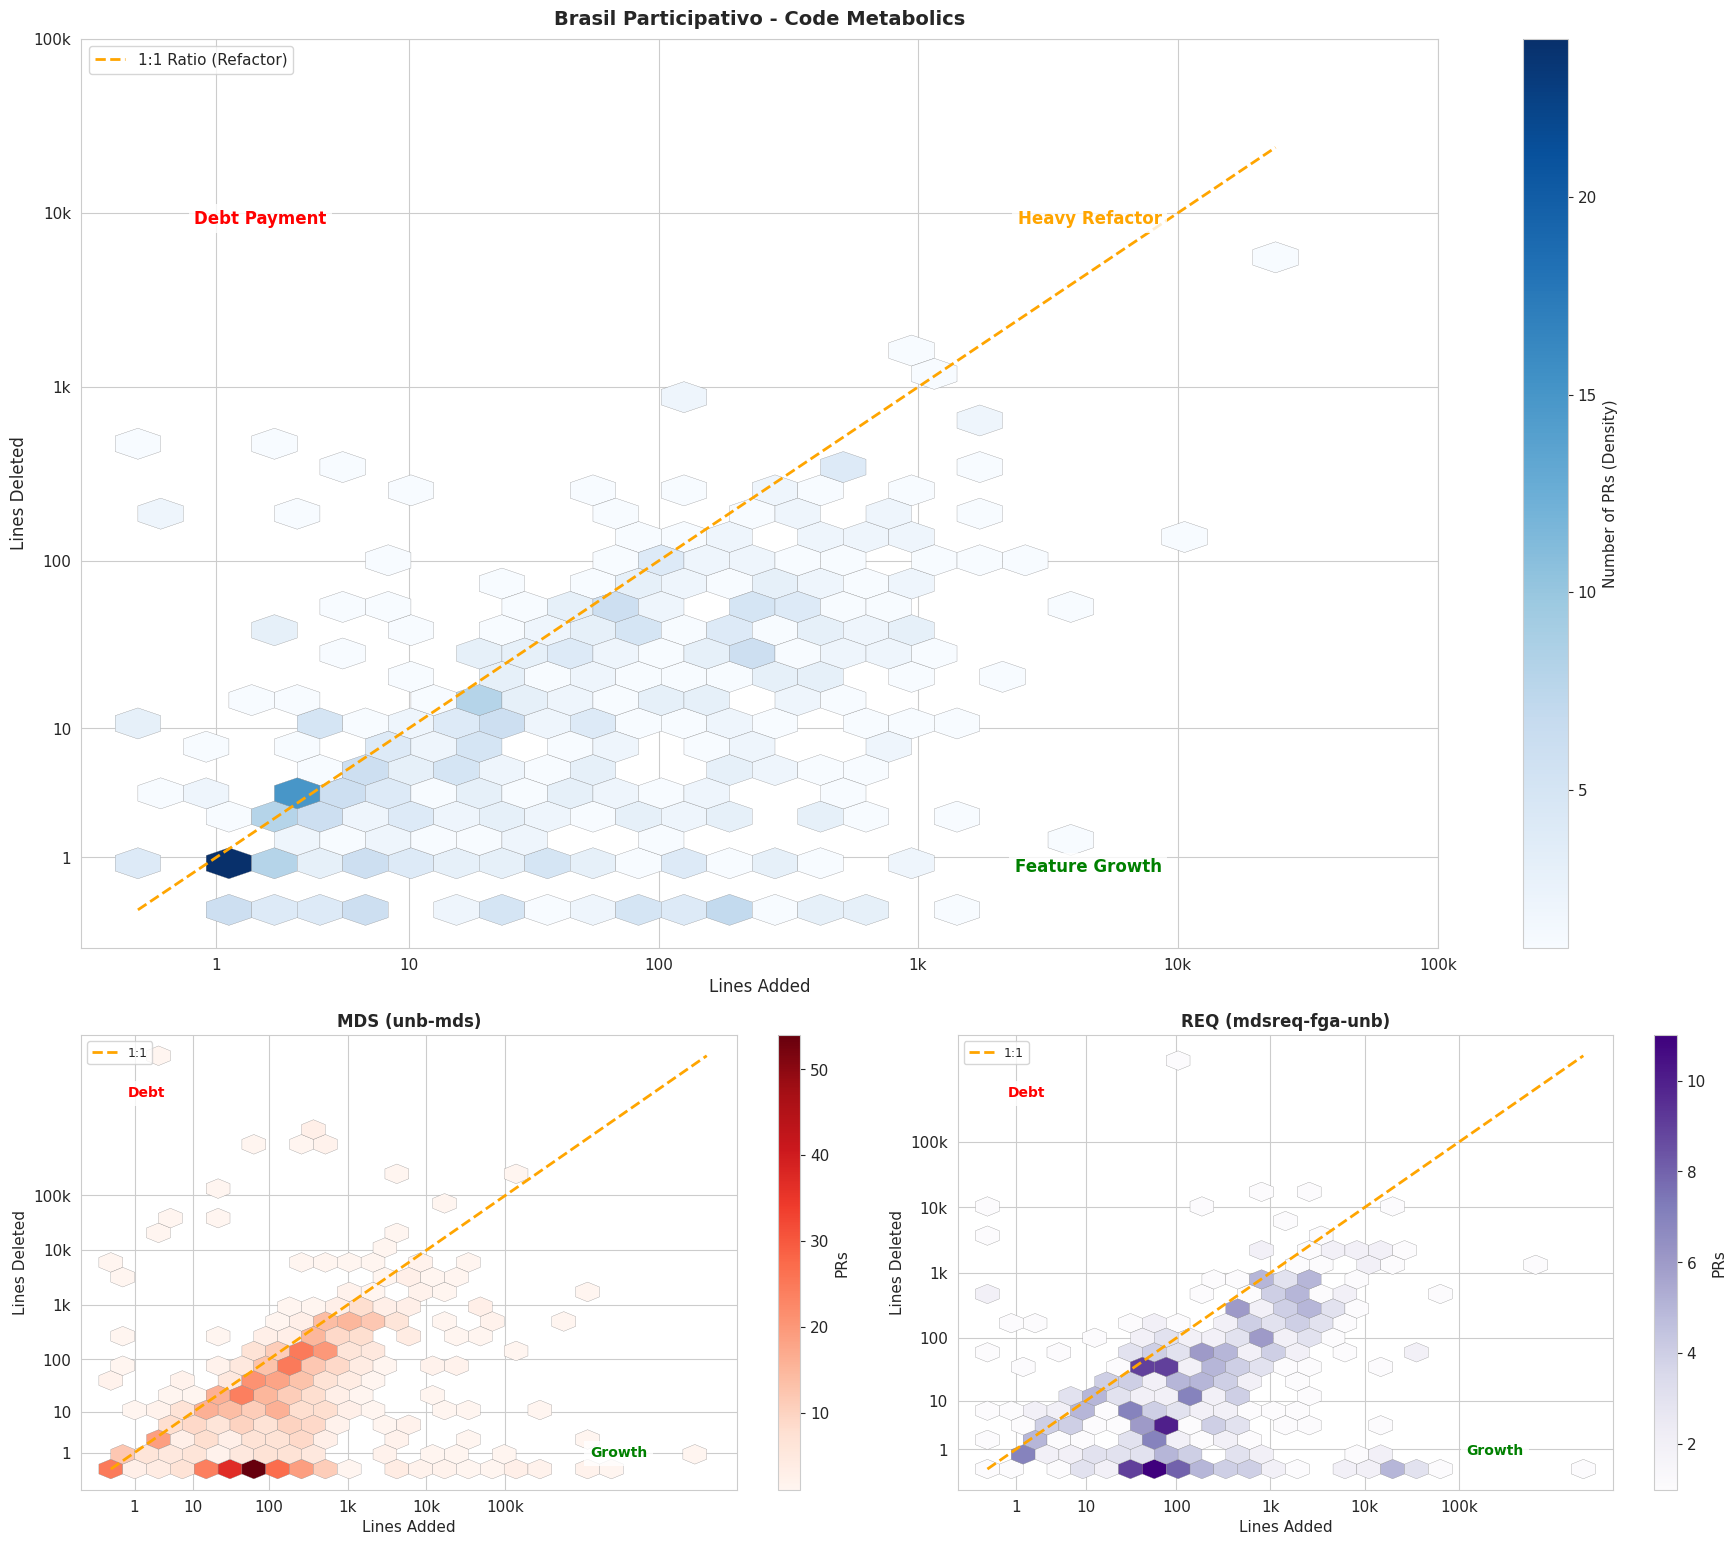

In [128]:
def plot_code_metabolics_all():
    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=(18, 16))
    gs = GridSpec(3, 2, figure=fig, height_ratios=[2, 1, 0], width_ratios=[1, 1])
    
    # Brasil Participativo
    ax1 = fig.add_subplot(gs[0, :])
    x_bp = np.log1p(df['additions'])
    y_bp = np.log1p(df['deletions'])
    hb1 = ax1.hexbin(x_bp, y_bp, gridsize=25, cmap='Blues', mincnt=1, edgecolors='gray', linewidths=0.2)
    plt.colorbar(hb1, ax=ax1, label='Number of PRs (Density)')
    max_val_bp = max(x_bp.max(), y_bp.max())
    ax1.plot([0, max_val_bp], [0, max_val_bp], '--', color='orange', linewidth=2, label='1:1 Ratio (Refactor)')
    ticks = [1, 10, 100, 1000, 10000, 100000]
    log_ticks = np.log1p(ticks)
    labels = ['1', '10', '100', '1k', '10k', '100k']
    ax1.set_xticks(log_ticks)
    ax1.set_xticklabels(labels)
    ax1.set_yticks(log_ticks)
    ax1.set_yticklabels(labels)
    ax1.text(max_val_bp * 0.9, 0.5, 'Feature Growth', color='green', fontweight='bold', ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax1.text(0.5, max_val_bp * 0.9, 'Debt Payment', color='red', fontweight='bold', ha='left', fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax1.text(max_val_bp * 0.9, max_val_bp * 0.9, 'Heavy Refactor', color='orange', fontweight='bold', ha='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax1.set_title(f'{org_title} - Code Metabolics', fontsize=14, fontweight='bold', pad=10)
    ax1.set_xlabel('Lines Added', fontsize=12)
    ax1.set_ylabel('Lines Deleted', fontsize=12)
    ax1.legend(loc='upper left')
    
    # MDS 
    ax2 = fig.add_subplot(gs[1, 0])
    x_mds = np.log1p(df_mds['additions'])
    y_mds = np.log1p(df_mds['deletions'])
    hb2 = ax2.hexbin(x_mds, y_mds, gridsize=25, cmap='Reds', mincnt=1, edgecolors='gray', linewidths=0.2)
    plt.colorbar(hb2, ax=ax2, label='PRs')
    max_val_mds = max(x_mds.max(), y_mds.max())
    ax2.plot([0, max_val_mds], [0, max_val_mds], '--', color='orange', linewidth=2, label='1:1')
    ax2.set_xticks(log_ticks)
    ax2.set_xticklabels(labels)
    ax2.set_yticks(log_ticks)
    ax2.set_yticklabels(labels)
    ax2.text(max_val_mds * 0.9, 0.5, 'Growth', color='green', fontweight='bold', ha='right', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax2.text(0.5, max_val_mds * 0.9, 'Debt', color='red', fontweight='bold', ha='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax2.set_title(f'{mds_title}', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Lines Added', fontsize=11)
    ax2.set_ylabel('Lines Deleted', fontsize=11)
    ax2.legend(loc='upper left', fontsize=9)
    
    # Requisitos 
    ax3 = fig.add_subplot(gs[1, 1])
    x_req = np.log1p(df_req['additions'])
    y_req = np.log1p(df_req['deletions'])
    hb3 = ax3.hexbin(x_req, y_req, gridsize=25, cmap='Purples', mincnt=1, edgecolors='gray', linewidths=0.2)
    plt.colorbar(hb3, ax=ax3, label='PRs')
    max_val_req = max(x_req.max(), y_req.max())
    ax3.plot([0, max_val_req], [0, max_val_req], '--', color='orange', linewidth=2, label='1:1')
    ax3.set_xticks(log_ticks)
    ax3.set_xticklabels(labels)
    ax3.set_yticks(log_ticks)
    ax3.set_yticklabels(labels)
    ax3.text(max_val_req * 0.9, 0.5, 'Growth', color='green', fontweight='bold', ha='right', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax3.text(0.5, max_val_req * 0.9, 'Debt', color='red', fontweight='bold', ha='left', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax3.set_title(f'{req_title}', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Lines Added', fontsize=11)
    ax3.set_ylabel('Lines Deleted', fontsize=11)
    ax3.legend(loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.show()

plot_code_metabolics_all()

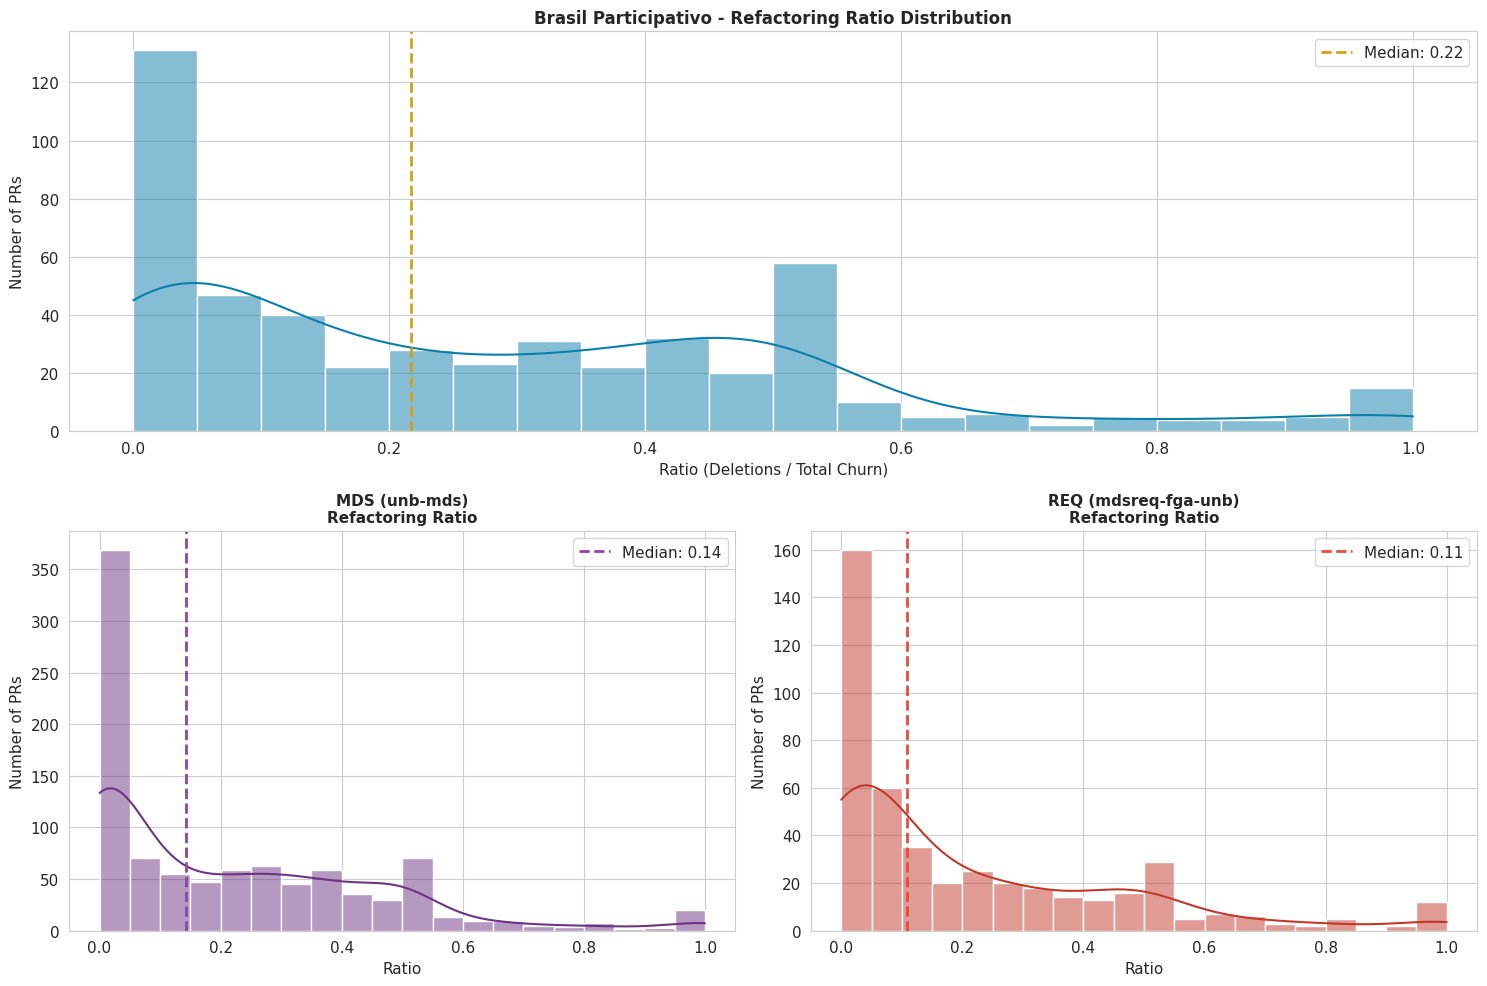

In [129]:
def plot_maintenance_patterns_comparison(df_bp, df_mds, df_req):
    def calculate_ratio(data):
        temp = data.copy()
        temp['refactor_ratio'] = temp.apply(lambda x: x['deletions'] / x['churn'] if x['churn'] > 0 else 0, axis=1)
        return temp

    df_bp_final = calculate_ratio(df_bp)
    df_mds_final = calculate_ratio(df_mds)
    df_req_final = calculate_ratio(df_req)

    fig = plt.figure(figsize=(15, 10))
    
    ax1 = fig.add_subplot(2, 1, 1)
    sns.histplot(df_bp_final['refactor_ratio'], kde=True, color=BP_PRIMARY, bins=20, ax=ax1)
    med_bp = df_bp_final['refactor_ratio'].median()
    ax1.axvline(med_bp, color=BP_ACCENT, linestyle='--', linewidth=2, label=f'Median: {med_bp:.2f}')
    ax1.set_title(f'{org_title} - Refactoring Ratio Distribution', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Ratio (Deletions / Total Churn)')
    ax1.set_ylabel('Number of PRs')
    ax1.legend()

    ax2 = fig.add_subplot(2, 2, 3)
    sns.histplot(df_mds_final['refactor_ratio'], kde=True, color=MDS_PRIMARY, bins=20, ax=ax2)
    med_mds = df_mds_final['refactor_ratio'].median()
    ax2.axvline(med_mds, color=MDS_SECONDARY, linestyle='--', linewidth=2, label=f'Median: {med_mds:.2f}')
    ax2.set_title(f'{mds_title}\nRefactoring Ratio', fontsize=11, fontweight='bold')
    ax2.set_xlabel('Ratio')
    ax2.set_ylabel('Number of PRs')
    ax2.legend()

    ax3 = fig.add_subplot(2, 2, 4)
    sns.histplot(df_req_final['refactor_ratio'], kde=True, color=REQ_PRIMARY, bins=20, ax=ax3)
    med_req = df_req_final['refactor_ratio'].median()
    ax3.axvline(med_req, color=REQ_SECONDARY, linestyle='--', linewidth=2, label=f'Median: {med_req:.2f}')
    ax3.set_title(f'{req_title}\nRefactoring Ratio', fontsize=11, fontweight='bold')
    ax3.set_xlabel('Ratio')
    ax3.set_ylabel('Number of PRs')
    ax3.legend()

    plt.tight_layout()
    plt.show()

plot_maintenance_patterns_comparison(df, df_mds, df_req)

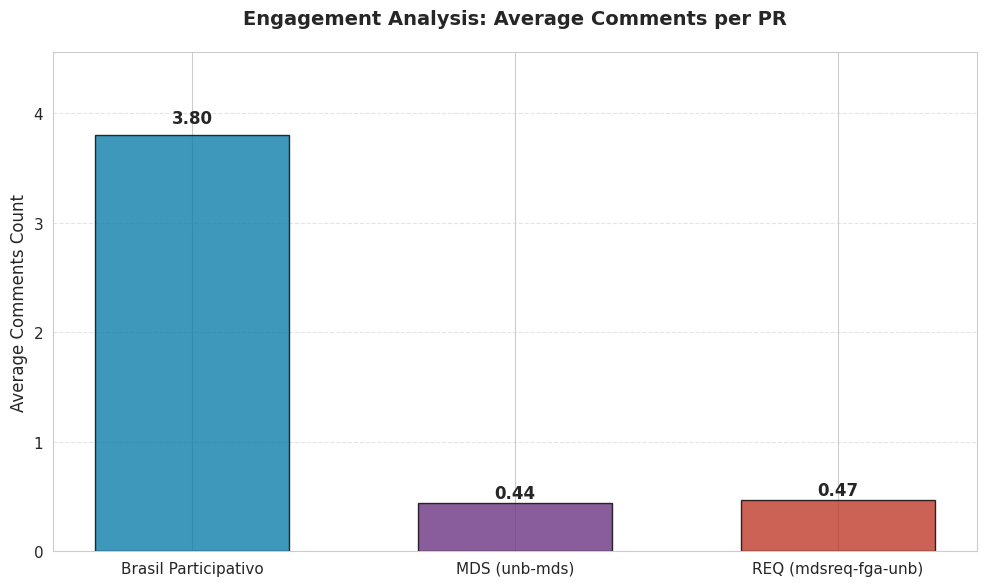

In [130]:
avg_comments_bp = df['comments'].mean()
avg_comments_mds = df_mds['comments'].mean()
avg_comments_req = df_req['comments'].mean()

x_labels = [org_title, mds_title, req_title]
y_values = [avg_comments_bp, avg_comments_mds, avg_comments_req]
bar_colors = [BP_PRIMARY, MDS_PRIMARY, REQ_PRIMARY]

plt.figure(figsize=(10, 6))
bars = plt.bar(x_labels, y_values, color=bar_colors, width=0.6, edgecolor='black', alpha=0.8)

plt.title('Engagement Analysis: Average Comments per PR', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Average Comments Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (height * 0.02), f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0, max(y_values) * 1.2)
plt.tight_layout()
plt.show()

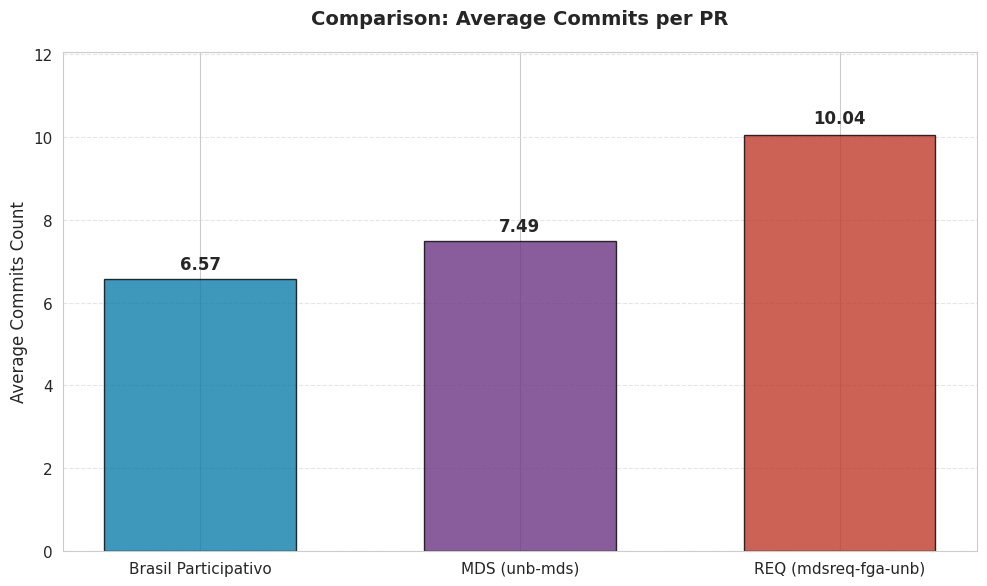

In [131]:
avg_commits_bp = df['commits'].mean()
avg_commits_mds = df_mds['commits'].mean()
avg_commits_req = df_req['commits'].mean()

x_labels = [org_title, mds_title, req_title]
y_values = [avg_commits_bp, avg_commits_mds, avg_commits_req]
bar_colors = [BP_PRIMARY, MDS_PRIMARY, REQ_PRIMARY]

plt.figure(figsize=(10, 6))
bars = plt.bar(x_labels, y_values, color=bar_colors, width=0.6, edgecolor='black', alpha=0.8)

plt.title('Comparison: Average Commits per PR', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Average Commits Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (height * 0.02), f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0, max(y_values) * 1.2)
plt.tight_layout()
plt.show()

/tmp/ipykernel_119892/3613681757.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  temp['week'] = temp['created_at'].dt.to_period('W')
/tmp/ipykernel_119892/3613681757.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  temp['week'] = temp['created_at'].dt.to_period('W')
/tmp/ipykernel_119892/3613681757.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  temp['week'] = temp['created_at'].dt.to_period('W')


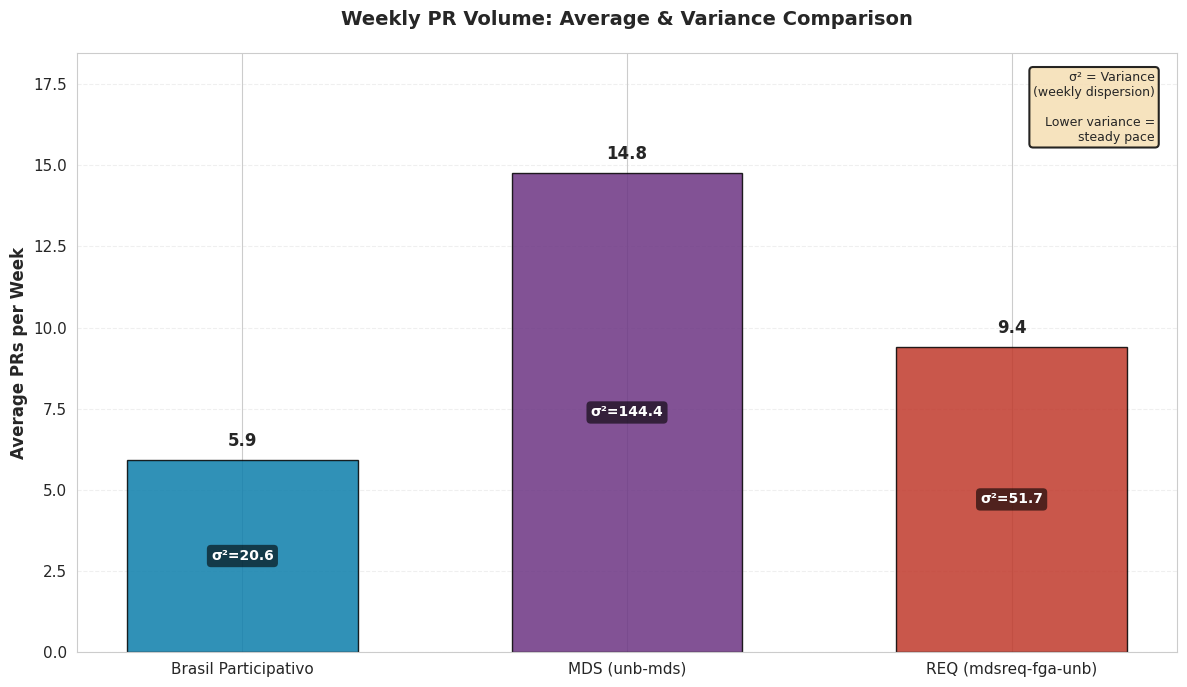

In [137]:
def plot_weekly_pr_volume_comparison(df_bp, df_mds, df_req):
    # Preparando dados
    def get_weekly_stats(data):
        temp = data.copy()
        temp['created_at'] = pd.to_datetime(temp['created_at'])
        temp['week'] = temp['created_at'].dt.to_period('W')
        weekly = temp.groupby('week').size()
        return weekly.mean(), weekly.var(), weekly.std()
    
    mean_bp, var_bp, std_bp = get_weekly_stats(df_bp)
    mean_mds, var_mds, std_mds = get_weekly_stats(df_mds)
    mean_req, var_req, std_req = get_weekly_stats(df_req)

    fig, ax = plt.subplots(figsize=(12, 7))
    
    x_labels = [org_title, mds_title, req_title]
    means = [mean_bp, mean_mds, mean_req]
    variances = [var_bp, var_mds, var_req]
    bar_colors = [BP_PRIMARY, MDS_PRIMARY, REQ_PRIMARY]
    
    x = np.arange(len(x_labels))
    bars = ax.bar(x, means, color=bar_colors, width=0.6, edgecolor='black', alpha=0.85)
    
    ax.set_ylabel('Average PRs per Week', fontsize=12, fontweight='bold')
    ax.set_title('Weekly PR Volume: Average & Variance Comparison', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    for i, (bar, mean_val, var_val) in enumerate(zip(bars, means, variances)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (max(means) * 0.02), 
                f'{mean_val:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        # Variância dentro ou próximo da barra
        ax.text(bar.get_x() + bar.get_width()/2., height/2, 
                f'σ²={var_val:.1f}', ha='center', va='center', 
                fontsize=10, color='white', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.6, edgecolor='none'))
    
    ax.set_ylim(0, max(means) * 1.25)
    
    textstr = 'σ² = Variance\n(weekly dispersion)\n\n'
    textstr += 'Lower variance =\nsteady pace'
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.85, edgecolor='black', linewidth=1.5)
    ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right', bbox=props)
    
    plt.tight_layout()
    plt.show()

plot_weekly_pr_volume_comparison(df, df_mds, df_req)

 <img src="assets/grafo.png" width="1000" />